In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### 1. Load Data

In [127]:
def get_data(name):
    return pd.read_csv(f'data/clinical/{name}.tsv', sep='\t')

dfs = {
    'clinical': get_data('clinical'),
    'exposure': get_data('exposure'),
    'family_history': get_data('family_history'),
    'follow_up': get_data('follow_up'),
    'pathology_detail': get_data('pathology_detail')
}

### 2. Clear Data

In [128]:
def is_dataframe_empty(df):
    """Проверяет, пуст ли DataFrame."""
    return df.empty or df.shape[0] == 0

# Удаление пустых DataFrame из словаря
dfs = {key: df for key, df in dfs.items() if not is_dataframe_empty(df)}

# Показ количества колонок и строк в датафрейме
def show_info_df(obj):
    for key, df in obj.items():
        print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")

show_info_df(dfs)

clinical: 106 rows, 158 columns
exposure: 48 rows, 35 columns


In [129]:
# clear empty cols
value_to_filter = "'--"

for key, df in dfs.items():
    # Определяем колонки, где все значения равны value_to_filter
    columns_to_remove = [col for col in df.columns if df[col].eq(value_to_filter).all()]
    
    # Удаляем колонки
    df.drop(columns=columns_to_remove, inplace=True)
    
    # Обновляем DataFrame в словаре
    dfs[key] = df

In [130]:
# Удалим df exposure (мало информации)
if 'exposure' in dfs:
    print(dfs['exposure'].apply(lambda x: x.unique()))

dfs.pop('exposure', None)
show_info_df(dfs)

case_id              [0030a28c-81aa-44b0-8be0-b35e1dcbf98c, 0bf573a...
case_submitter_id    [TCGA-FA-A7Q1, TCGA-FA-A6HN, TCGA-GS-A9U4, TCG...
project_id                                                 [TCGA-DLBC]
alcohol_history                                         [Not Reported]
dtype: object
clinical: 106 rows, 33 columns


In [131]:
df = dfs['clinical']
df.head()

,case_id,case_submitter_id,project_id,age_at_index,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,...,prior_malignancy,prior_treatment,progression_or_recurrence,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_grade,year_of_diagnosis,treatment_or_therapy,treatment_type
0,0030a28c-81aa-44b0-8be0-b35e1dcbf98c,TCGA-FA-A7Q1,TCGA-DLBC,61,-22454,248,not hispanic or latino,female,asian,Dead,...,no,No,not reported,Intra-abdominal lymph nodes,No,Intra-abdominal lymph nodes,not reported,2013,yes,"Pharmaceutical Therapy, NOS"
1,0030a28c-81aa-44b0-8be0-b35e1dcbf98c,TCGA-FA-A7Q1,TCGA-DLBC,61,-22454,248,not hispanic or latino,female,asian,Dead,...,no,No,not reported,Intra-abdominal lymph nodes,No,Intra-abdominal lymph nodes,not reported,2013,no,"Radiation Therapy, NOS"
2,0bf573ac-cd1e-42d8-90cf-b30d7b08679c,TCGA-FA-A6HN,TCGA-DLBC,73,-27025,58,not hispanic or latino,male,asian,Dead,...,no,No,not reported,"Lymph nodes of head, face and neck",No,"Lymph nodes of head, face and neck",not reported,2013,no,"Radiation Therapy, NOS"
3,0bf573ac-cd1e-42d8-90cf-b30d7b08679c,TCGA-FA-A6HN,TCGA-DLBC,73,-27025,58,not hispanic or latino,male,asian,Dead,...,no,No,not reported,"Lymph nodes of head, face and neck",No,"Lymph nodes of head, face and neck",not reported,2013,yes,"Pharmaceutical Therapy, NOS"
4,0e251c03-bf86-4ed8-b45d-3cbc97160502,TCGA-GS-A9U4,TCGA-DLBC,27,-10075,391,hispanic or latino,female,white,Dead,...,no,No,not reported,"Lymph nodes of head, face and neck",No,"Lymph nodes of head, face and neck",not reported,2011,yes,"Pharmaceutical Therapy, NOS"


In [132]:
# Заменяем специальные значения на NaN
pd.set_option('future.no_silent_downcasting', True)

def replace_special_values(df, special_values):
    # Используем метод replace для замены специальных значений
    df = df.replace(special_values, np.nan)
    return df

special_values = ["'--", "not reported"]

df = replace_special_values(df, special_values)

df.apply(lambda x: x.unique())

case_id                             [0030a28c-81aa-44b0-8be0-b35e1dcbf98c, 0bf573a...
case_submitter_id                   [TCGA-FA-A7Q1, TCGA-FA-A6HN, TCGA-GS-A9U4, TCG...
project_id                                                                [TCGA-DLBC]
age_at_index                        [61, 73, 27, 60, 67, 72, 45, nan, 28, 63, 23, ...
days_to_birth                       [-22454, -27025, -10075, -21959, -24590, -2652...
days_to_death                       [248, 58, 391, nan, 595, 6425, 1252, 3553, 708...
ethnicity                           [not hispanic or latino, hispanic or latino, nan]
gender                                                            [female, male, nan]
race                                   [asian, white, nan, black or african american]
vital_status                                                       [Dead, Alive, nan]
year_of_birth                       [1952, 1940, 1984, 1951, 1945, 1959, nan, 1982...
year_of_death                                         

In [133]:
df.shape

(106, 33)

In [134]:
df.apply(lambda x: x.unique())

case_id                             [0030a28c-81aa-44b0-8be0-b35e1dcbf98c, 0bf573a...
case_submitter_id                   [TCGA-FA-A7Q1, TCGA-FA-A6HN, TCGA-GS-A9U4, TCG...
project_id                                                                [TCGA-DLBC]
age_at_index                        [61, 73, 27, 60, 67, 72, 45, nan, 28, 63, 23, ...
days_to_birth                       [-22454, -27025, -10075, -21959, -24590, -2652...
days_to_death                       [248, 58, 391, nan, 595, 6425, 1252, 3553, 708...
ethnicity                           [not hispanic or latino, hispanic or latino, nan]
gender                                                            [female, male, nan]
race                                   [asian, white, nan, black or african american]
vital_status                                                       [Dead, Alive, nan]
year_of_birth                       [1952, 1940, 1984, 1951, 1945, 1959, nan, 1982...
year_of_death                                         

In [135]:
# Удалим все колонки в кторых уникальные значения только типа
# '--, No, not reported, 0
values_to_check = ["'--", "No", "no", "not reported", "0", np.nan]

def remove_columns_with_only_specific_values(df, values):
    columns_to_remove = []
    
    for column in df.columns:
        unique_values = set(df[column].unique())
        if unique_values.issubset(set(values)):
            columns_to_remove.append(column)
    
    return df.drop(columns=columns_to_remove)

df = remove_columns_with_only_specific_values(df, values_to_check)

df.shape

(106, 26)

In [136]:
# Удалим неинформативные строки
non_identifier_cols = ['age_at_index', 'days_to_birth', 'days_to_death', 'ethnicity', 'gender',
                        'race', 'vital_status', 'year_of_birth', 'year_of_death', 'age_at_diagnosis',
                        'ann_arbor_b_symptoms', 'ann_arbor_clinical_stage', 'ann_arbor_extranodal_involvement',
                        'days_to_last_follow_up', 'icd_10_code', 'morphology', 'primary_diagnosis',
                        'prior_treatment', 'site_of_resection_or_biopsy', 'tissue_or_organ_of_origin',
                        'year_of_diagnosis', 'treatment_or_therapy', 'treatment_type']

# Удаление строк, где все значения в non_identifier_cols равны NaN
df = df[~df[non_identifier_cols].isna().all(axis=1)]
df.shape

(96, 26)

In [137]:
# Определение столбцов, которые нужно удалить (если одно уникальное значение)
def get_columns_to_remove(df):
    columns_to_remove = []
    
    for column in df.columns:
        unique_values = df[column].unique()
        # Проверка, состоит ли столбец только из одного уникального значения
        if len(unique_values) == 1:
            columns_to_remove.append(column)
    
    return columns_to_remove

columns_to_remove = get_columns_to_remove(df)
print(f'Stub column names to remove: {columns_to_remove}')

df = df.drop(columns=columns_to_remove)

Stub column names to remove: ['project_id', 'morphology', 'primary_diagnosis']


In [138]:
# Delete column if Nan > 20%
nan_percentage = df.isna().mean() * 100
columns_to_drop = nan_percentage[nan_percentage > 20].index

print(df['ann_arbor_clinical_stage'].isna().mean() * 100)
print("Удаленные колонки:")
print(columns_to_drop)
print("\nОчищенный DataFrame:")
print(df)

12.5
Удаленные колонки:
Index(['days_to_death', 'year_of_death'], dtype='object')

Очищенный DataFrame:
                                  case_id case_submitter_id age_at_index  \
0    0030a28c-81aa-44b0-8be0-b35e1dcbf98c      TCGA-FA-A7Q1           61   
1    0030a28c-81aa-44b0-8be0-b35e1dcbf98c      TCGA-FA-A7Q1           61   
2    0bf573ac-cd1e-42d8-90cf-b30d7b08679c      TCGA-FA-A6HN           73   
3    0bf573ac-cd1e-42d8-90cf-b30d7b08679c      TCGA-FA-A6HN           73   
4    0e251c03-bf86-4ed8-b45d-3cbc97160502      TCGA-GS-A9U4           27   
..                                    ...               ...          ...   
101  f8cf647b-1447-4ac3-8c43-bef07765cabf      TCGA-G8-6326           52   
102  f978cb0f-d319-4c01-b4c5-23ae1403a106      TCGA-FF-8047           38   
103  f978cb0f-d319-4c01-b4c5-23ae1403a106      TCGA-FF-8047           38   
104  fdecb74f-ac4e-46b1-b23a-5f7fde96ef9f      TCGA-GS-A9U3           77   
105  fdecb74f-ac4e-46b1-b23a-5f7fde96ef9f      TCGA-GS-A9U3 

In [139]:
df.apply(lambda x: x.unique())

case_id                             [0030a28c-81aa-44b0-8be0-b35e1dcbf98c, 0bf573a...
case_submitter_id                   [TCGA-FA-A7Q1, TCGA-FA-A6HN, TCGA-GS-A9U4, TCG...
age_at_index                        [61, 73, 27, 60, 67, 72, 45, 28, 63, 23, 46, 5...
days_to_birth                       [-22454, -27025, -10075, -21959, -24590, -2652...
days_to_death                       [248, 58, 391, nan, 595, 6425, 1252, 3553, 708...
ethnicity                                [not hispanic or latino, hispanic or latino]
gender                                                                 [female, male]
race                                        [asian, white, black or african american]
vital_status                                                            [Dead, Alive]
year_of_birth                       [1952, 1940, 1984, 1951, 1945, 1959, 1982, 194...
year_of_death                                           [nan, 2012, 2001, 2004, 2009]
age_at_diagnosis                    [22454, 27025, 100

In [140]:
cols_with_nan = df.columns[df.isna().any()].tolist()
cols_with_nan

['days_to_death',
 'year_of_death',
 'ann_arbor_b_symptoms',
 'ann_arbor_clinical_stage',
 'ann_arbor_extranodal_involvement',
 'days_to_last_follow_up',
 'treatment_or_therapy']

In [141]:
# Заполнение NaN значений
df['ann_arbor_b_symptoms'] = df['ann_arbor_b_symptoms'].fillna('Unknown')
df['ann_arbor_clinical_stage'] = df['ann_arbor_clinical_stage'].fillna('Unknown')
df['ann_arbor_extranodal_involvement'] = df['ann_arbor_extranodal_involvement'].fillna('Unknown')
df['treatment_or_therapy'] = df['treatment_or_therapy'].fillna('Unknown')

# Преобразование столбца в числовой тип
df['days_to_last_follow_up'] = pd.to_numeric(df['days_to_last_follow_up'], errors='coerce')
df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')
df['year_of_death'] = pd.to_numeric(df['year_of_death'], errors='coerce')

# Заполнение NaN значений медианой для числового столбца
median_days_to_last_follow_up = df['days_to_last_follow_up'].median()
df['days_to_last_follow_up'] = df['days_to_last_follow_up'].fillna(median_days_to_last_follow_up)

median_days_to_death = df['days_to_death'].median()
df['days_to_death'] = df['days_to_death'].fillna(median_days_to_death)

median_year_of_death = df['year_of_death'].median()
df['year_of_death'] = df['year_of_death'].fillna(median_year_of_death)

In [142]:
df.isna().any().any()

False

In [143]:
df.apply(lambda x: x.unique())

case_id                             [0030a28c-81aa-44b0-8be0-b35e1dcbf98c, 0bf573a...
case_submitter_id                   [TCGA-FA-A7Q1, TCGA-FA-A6HN, TCGA-GS-A9U4, TCG...
age_at_index                        [61, 73, 27, 60, 67, 72, 45, 28, 63, 23, 46, 5...
days_to_birth                       [-22454, -27025, -10075, -21959, -24590, -2652...
days_to_death                       [248.0, 58.0, 391.0, 595.0, 6425.0, 1252.0, 35...
ethnicity                                [not hispanic or latino, hispanic or latino]
gender                                                                 [female, male]
race                                        [asian, white, black or african american]
vital_status                                                            [Dead, Alive]
year_of_birth                       [1952, 1940, 1984, 1951, 1945, 1959, 1982, 194...
year_of_death                                        [2009.0, 2012.0, 2001.0, 2004.0]
age_at_diagnosis                    [22454, 27025, 100

In [144]:
# work with treatment_type & treatment_or_therapy

def check_treatment_consistency(df):
    # Создаем таблицу соответствий между treatment_or_therapy и treatment_type
    treatment_consistency = df.groupby('treatment_or_therapy')['treatment_type'].unique().reset_index()
    treatment_consistency.columns = ['treatment_or_therapy', 'treatment_types']
    
    return treatment_consistency

# Проверить соответствие
treatment_consistency = check_treatment_consistency(df)

treatment_consistency

,treatment_or_therapy,treatment_types
0,Unknown,"[Radiation Therapy, NOS, Pharmaceutical Therap..."
1,no,"[Radiation Therapy, NOS, Pharmaceutical Therap..."
2,yes,"[Pharmaceutical Therapy, NOS, Radiation Therap..."


In [145]:
df['treatment_or_therapy'] = df['treatment_or_therapy'].replace('Unknown', 'no')
treatment_consistency = check_treatment_consistency(df)
treatment_consistency

,treatment_or_therapy,treatment_types
0,no,"[Radiation Therapy, NOS, Pharmaceutical Therap..."
1,yes,"[Pharmaceutical Therapy, NOS, Radiation Therap..."


In [146]:
# create treatment_category
df['treatment_category'] = df['treatment_or_therapy'] + ' - ' + df['treatment_type']

# unique categories
category_mapping = {
    'no - Radiation Therapy, NOS': 0,
    'no - Pharmaceutical Therapy, NOS': 1,
    'yes - Radiation Therapy, NOS': 2,
    'yes - Pharmaceutical Therapy, NOS': 3
}

df['treatment_category'] = df['treatment_category'].map(category_mapping)

# drop treatment_or_therapy, treatment_type
df = df.drop(columns=['treatment_or_therapy', 'treatment_type'])

In [147]:
# remove duplicate rows

# Группировка по 'case_id' и преобразование значений в список
grouped = df.groupby('case_id')['treatment_category'].apply(lambda x: tuple(sorted(x))).reset_index(name='sorted_treatment_category')

# Создание словаря уникальных пар и присвоение уникальных индексов
unique_pairs = {v: i for i, v in enumerate(sorted(grouped['sorted_treatment_category'].unique()))}
grouped['treatment_group'] = grouped['sorted_treatment_category'].map(unique_pairs)

# Объединение с исходным DataFrame
df = df.merge(grouped[['case_id', 'treatment_group']], on='case_id', how='left')

# Удаление столбца 'treatment_category'
df = df.drop(columns='treatment_category')

# Удаление дубликатов, оставив только одну строку для каждого case_id
df = df.drop_duplicates()

df.head(12)

,case_id,case_submitter_id,age_at_index,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,year_of_birth,...,ann_arbor_b_symptoms,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,days_to_last_follow_up,icd_10_code,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_group
0,0030a28c-81aa-44b0-8be0-b35e1dcbf98c,TCGA-FA-A7Q1,61,-22454,248.0,not hispanic or latino,female,asian,Dead,1952,...,No,Stage I,No,22.0,C48.1,No,Intra-abdominal lymph nodes,Intra-abdominal lymph nodes,2013,1
2,0bf573ac-cd1e-42d8-90cf-b30d7b08679c,TCGA-FA-A6HN,73,-27025,58.0,not hispanic or latino,male,asian,Dead,1940,...,No,Unknown,No,6.0,C83.3,No,"Lymph nodes of head, face and neck","Lymph nodes of head, face and neck",2013,1
4,0e251c03-bf86-4ed8-b45d-3cbc97160502,TCGA-GS-A9U4,27,-10075,391.0,hispanic or latino,female,white,Dead,1984,...,No,Stage II,No,832.0,C83.3,No,"Lymph nodes of head, face and neck","Lymph nodes of head, face and neck",2011,1
6,0e9fcccc-0630-408d-a121-2c6413824cb7,TCGA-FF-8062,60,-21959,595.0,not hispanic or latino,female,asian,Alive,1951,...,No,Stage I,Yes,679.0,C83.3,No,Thyroid gland,Thyroid gland,2011,1
8,1843c82e-7a35-474f-9f79-c0a9af9aa09c,TCGA-FA-A4BB,67,-24590,595.0,not hispanic or latino,male,white,Alive,1945,...,Yes,Stage IV,Yes,132.0,C83.3,No,Lymph nodes of axilla or arm,Lymph nodes of axilla or arm,2012,1
10,1d0db5d7-39ca-466d-96b3-0d278c5ea768,TCGA-FF-A7CW,72,-26520,595.0,not hispanic or latino,male,asian,Alive,1940,...,No,Stage II,Yes,791.0,C83.3,No,"Lymph nodes of head, face and neck","Lymph nodes of head, face and neck",2012,1
12,1ea575f1-f731-408b-a629-f5f4abab569e,TCGA-GS-A9TU,45,-16720,595.0,hispanic or latino,male,white,Alive,1959,...,No,Stage II,No,3897.0,C83.3,No,Lymph nodes of inguinal region or leg,Lymph nodes of inguinal region or leg,2004,2
14,1f971af1-6772-4fe6-8d35-bbe527a037fe,TCGA-FF-8041,28,-10466,595.0,not hispanic or latino,female,asian,Alive,1982,...,No,Stage I,No,1081.0,C38.1,No,Anterior mediastinum,Anterior mediastinum,2010,1
16,25ff86af-beb4-480c-b706-f3fe0306f7cf,TCGA-RQ-A68N,63,-23127,595.0,hispanic or latino,male,white,Alive,1949,...,Unknown,Unknown,Unknown,788.0,C71.7,No,Brain stem,Brain stem,2012,1
18,29aff186-c321-4ff9-b81b-105e27e620ff,TCGA-GS-A9TW,23,-8493,595.0,hispanic or latino,female,white,Alive,1987,...,No,Stage II,No,1617.0,C83.3,No,Lymph nodes of axilla or arm,Lymph nodes of axilla or arm,2010,2


In [148]:
# delete case_id, case_submitter_id
df = df.drop(columns=['case_id', 'case_submitter_id'])
df.shape

(48, 20)

In [149]:
df.head()

,age_at_index,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,year_of_birth,year_of_death,age_at_diagnosis,ann_arbor_b_symptoms,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,days_to_last_follow_up,icd_10_code,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_group
0,61,-22454,248.0,not hispanic or latino,female,asian,Dead,1952,2009.0,22454,No,Stage I,No,22.0,C48.1,No,Intra-abdominal lymph nodes,Intra-abdominal lymph nodes,2013,1
2,73,-27025,58.0,not hispanic or latino,male,asian,Dead,1940,2009.0,27025,No,Unknown,No,6.0,C83.3,No,"Lymph nodes of head, face and neck","Lymph nodes of head, face and neck",2013,1
4,27,-10075,391.0,hispanic or latino,female,white,Dead,1984,2012.0,10075,No,Stage II,No,832.0,C83.3,No,"Lymph nodes of head, face and neck","Lymph nodes of head, face and neck",2011,1
6,60,-21959,595.0,not hispanic or latino,female,asian,Alive,1951,2009.0,21959,No,Stage I,Yes,679.0,C83.3,No,Thyroid gland,Thyroid gland,2011,1
8,67,-24590,595.0,not hispanic or latino,male,white,Alive,1945,2009.0,24590,Yes,Stage IV,Yes,132.0,C83.3,No,Lymph nodes of axilla or arm,Lymph nodes of axilla or arm,2012,1


In [150]:
# delete indetical column
if 'site_of_resection_or_biopsy' in list(df.columns):
    indentical = df['tissue_or_organ_of_origin'].equals(df['site_of_resection_or_biopsy'])

    if indentical:
        df = df.drop(columns='site_of_resection_or_biopsy')

In [151]:
df.shape

(48, 19)

### 3. Encoding

In [152]:
categorical_columns = [
    'ethnicity', 'gender', 'race', 'vital_status',
    'ann_arbor_b_symptoms', 'ann_arbor_clinical_stage',
    'ann_arbor_extranodal_involvement', 'prior_treatment',
    'icd_10_code', 'tissue_or_organ_of_origin'
]

df['ann_arbor_clinical_stage_str'] = df['ann_arbor_clinical_stage']

def encode_column(column):
    unique_values = column.unique()
    value_map = {value: idx for idx, value in enumerate(unique_values)}
    return column.map(value_map)

for col in categorical_columns:
    df[col] = encode_column(df[col])

df.apply(lambda x: x.unique())

age_at_index                        [61, 73, 27, 60, 67, 72, 45, 28, 63, 23, 46, 5...
days_to_birth                       [-22454, -27025, -10075, -21959, -24590, -2652...
days_to_death                       [248.0, 58.0, 391.0, 595.0, 6425.0, 1252.0, 35...
ethnicity                                                                      [0, 1]
gender                                                                         [0, 1]
race                                                                        [0, 1, 2]
vital_status                                                                   [0, 1]
year_of_birth                       [1952, 1940, 1984, 1951, 1945, 1959, 1982, 194...
year_of_death                                        [2009.0, 2012.0, 2001.0, 2004.0]
age_at_diagnosis                    [22454, 27025, 10075, 21959, 24590, 26520, 167...
ann_arbor_b_symptoms                                                        [0, 1, 2]
ann_arbor_clinical_stage                              

In [153]:
df.T

,0,2,4,6,8,10,12,14,16,18,...,76,78,80,82,84,86,88,90,92,94
age_at_index,61,73,27,60,67,72,45,28,63,23,...,69,54,51,57,74,61,46,52,38,77
days_to_birth,-22454,-27025,-10075,-21959,-24590,-26520,-16720,-10466,-23127,-8493,...,-25256,-20087,-18691,-21005,-27255,-22471,-17023,-19238,-13996,-28474
days_to_death,248.0,58.0,391.0,595.0,595.0,595.0,595.0,595.0,595.0,595.0,...,595.0,595.0,595.0,595.0,595.0,313.0,595.0,595.0,595.0,595.0
ethnicity,0,0,1,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,1
gender,0,1,0,0,1,1,1,0,1,0,...,1,0,1,0,1,1,0,1,0,0
race,0,0,1,0,1,0,1,0,1,1,...,1,0,1,0,0,0,1,1,0,1
vital_status,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
year_of_birth,1952,1940,1984,1951,1945,1940,1959,1982,1949,1987,...,1939,1959,1961,1953,1936,1951,1964,1957,1973,1928
year_of_death,2009.0,2009.0,2012.0,2009.0,2009.0,2009.0,2009.0,2009.0,2009.0,2009.0,...,2009.0,2009.0,2009.0,2009.0,2009.0,2012.0,2009.0,2009.0,2009.0,2009.0
age_at_diagnosis,22454,27025,10075,21959,24590,26520,16720,10466,23127,8493,...,25256,20087,18691,21005,27255,22471,17023,19238,13996,28474


### 3. Correlation

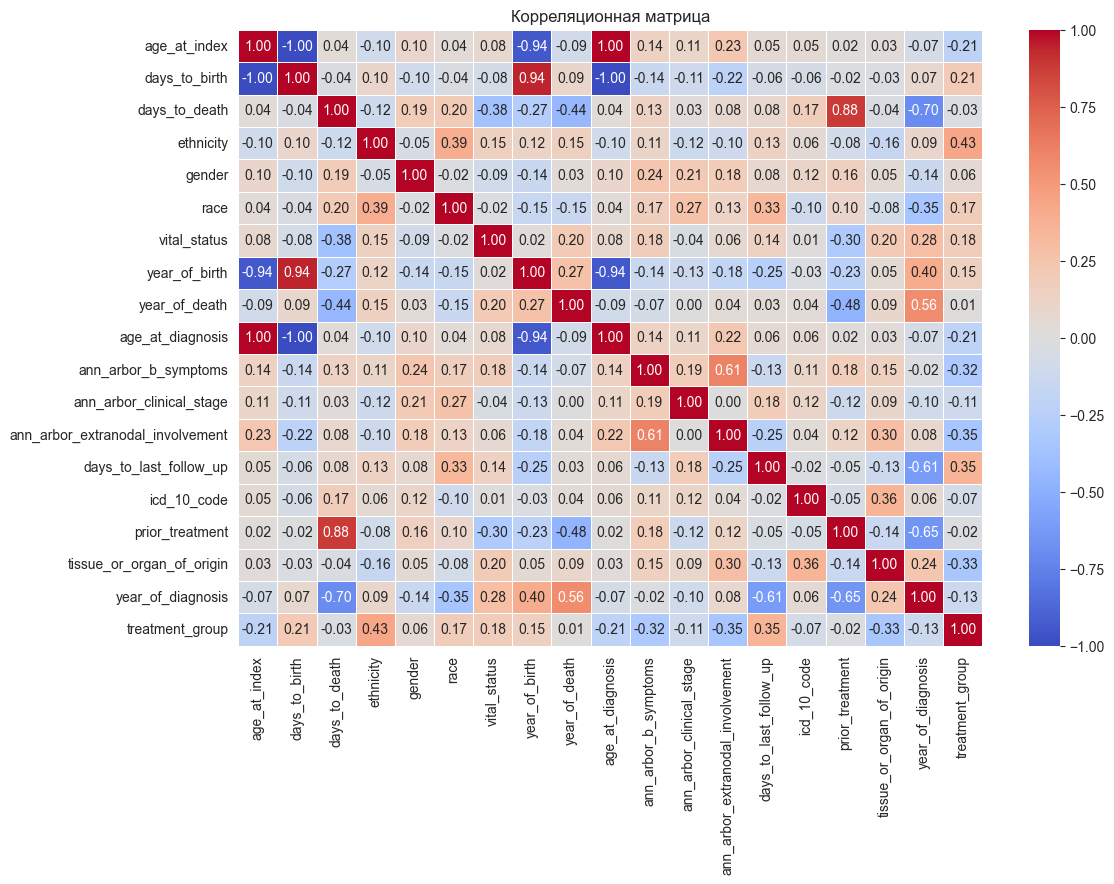

In [154]:
df_temp = df.drop(columns='ann_arbor_clinical_stage_str')
correlation_matrix = df_temp.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

#### large coeficients
age_at_index days_to_birth -1
age_at_index year_of_birth -0.94
age_at_index age_at_diagnosis 1
days_to_birth age_at_diagnosis -1
days_to_birth year_of_birth 0.94
days_to_death prior_treatment 0.88

In [155]:
# Оставим age_at_diagnosis так как он является самым понятным и прямым показателем возраста пациента на момент диагноза, что часто является важной информацией в медицинских исследованиях.
df = df.drop(columns=['age_at_index', 'days_to_birth', 'year_of_birth', 'prior_treatment'])
df.head()

,days_to_death,ethnicity,gender,race,vital_status,year_of_death,age_at_diagnosis,ann_arbor_b_symptoms,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,days_to_last_follow_up,icd_10_code,tissue_or_organ_of_origin,year_of_diagnosis,treatment_group,ann_arbor_clinical_stage_str
0,248.0,0,0,0,0,2009.0,22454,0,0,0,22.0,0,0,2013,1,Stage I
2,58.0,0,1,0,0,2009.0,27025,0,1,0,6.0,1,1,2013,1,Unknown
4,391.0,1,0,1,0,2012.0,10075,0,2,0,832.0,1,1,2011,1,Stage II
6,595.0,0,0,0,1,2009.0,21959,0,0,1,679.0,1,2,2011,1,Stage I
8,595.0,0,1,1,1,2009.0,24590,1,3,1,132.0,1,3,2012,1,Stage IV


In [156]:
# Описательная статистика для числовых столбцов
numeric_columns = ['age_at_diagnosis', 'days_to_last_follow_up', 'year_of_diagnosis']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age_at_diagnosis,48.0,20731.354167,5107.471500,8493.0,16998.25,21146.5,24607.75,30256.0
days_to_last_follow_up,48.0,1228.291667,1251.001947,0.0,528.75,832.0,1425.00,5980.0
year_of_diagnosis,48.0,2009.145833,5.031770,1987.0,2009.00,2011.0,2012.00,2013.0


<b>Возраст при диагностировании (age_at_diagnosis)</b>

Среднее значение: 56.27 лет
Медиана: 57.5 лет
Минимальное значение: 23 года
Максимальное значение: 82 года
Интерквартильный размах (IQR): 46 - 67 лет

<b>Количество дней до последнего наблюдения (days_to_last_follow_up)</b>

Среднее значение: 1228.29 дней
Медиана: 832 дней
Минимальное значение: 0 дней
Максимальное значение: 5980 дней
Интерквартильный размах (IQR): 528.75 - 1425 дней

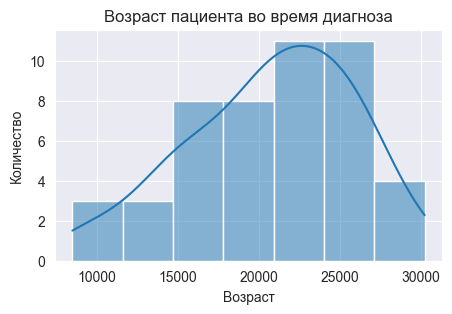

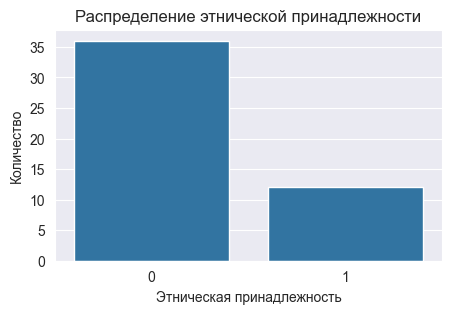

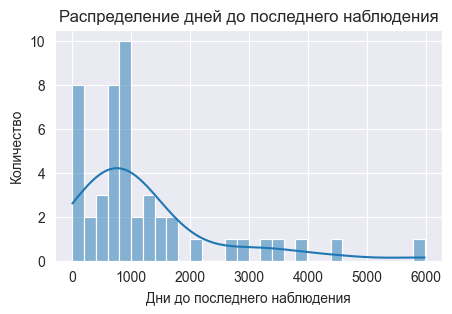

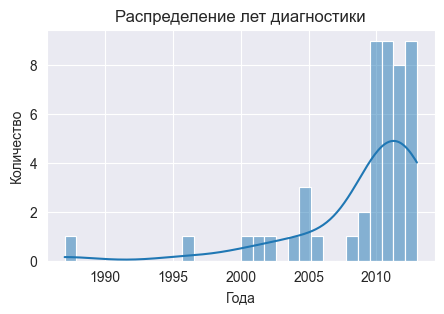

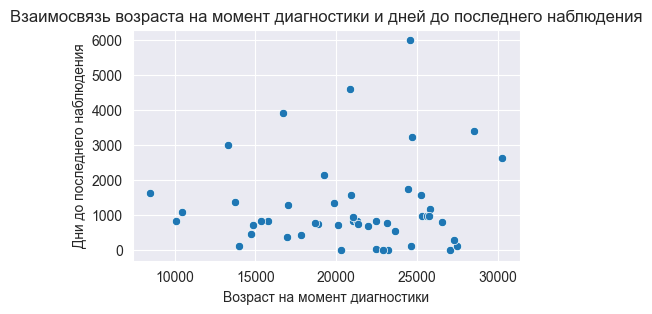

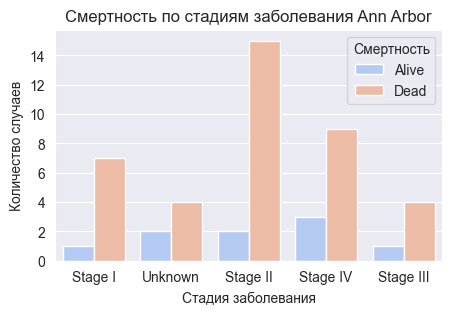

In [174]:
# Визуализация распределения возрастов
plt.figure(figsize=(5, 3))
sns.histplot(df['age_at_diagnosis'].dropna(), kde=True)
plt.title('Возраст пациента во время диагноза')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

# Визуализация распределения этнической принадлежности
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='ethnicity')
plt.title('Распределение этнической принадлежности')
plt.xlabel('Этническая принадлежность')
plt.ylabel('Количество')
plt.show()

# Визуализация распределения дней до последнего наблюдения
plt.figure(figsize=(5, 3))
sns.histplot(data=df, x='days_to_last_follow_up', bins=30, kde=True)
plt.title('Распределение дней до последнего наблюдения')
plt.xlabel('Дни до последнего наблюдения')
plt.ylabel('Количество')
plt.show()

# Визуализация распределения лет диагностики пациента
plt.figure(figsize=(5, 3))
sns.histplot(data=df, x='year_of_diagnosis', bins=30, kde=True)
plt.title('Распределение лет диагностики')
plt.xlabel('Года')
plt.ylabel('Количество')
plt.show()

# Взаимосвязь возраста на момент диагностики и дней до последнего наблюдения
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df, x='age_at_diagnosis', y='days_to_last_follow_up')
plt.title('Взаимосвязь возраста на момент диагностики и дней до последнего наблюдения')
plt.xlabel('Возраст на момент диагностики')
plt.ylabel('Дни до последнего наблюдения')
plt.show()

# Создание графика зависимости смертности от стадии заболевания
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='ann_arbor_clinical_stage_str', hue='vital_status', palette='coolwarm')
plt.title('Смертность по стадиям заболевания Ann Arbor')
plt.xlabel('Стадия заболевания')
plt.ylabel('Количество случаев')
plt.legend(title='Смертность', labels=['Alive', 'Dead'])
plt.show()

### Гипотезы

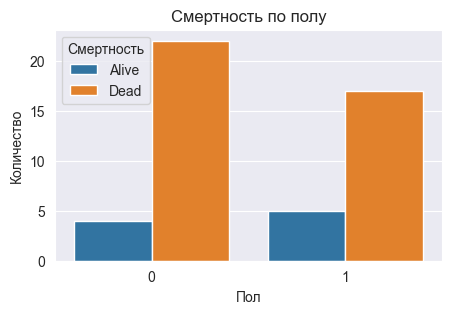

In [175]:
# Визуализация смертности по полу
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='gender', hue='vital_status')
plt.title('Смертность по полу')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.legend(title='Смертность', labels=['Alive', 'Dead'])
plt.show()

In [176]:
# Проверка гипотезы о зависимости смертности от пола
contingency_table = pd.crosstab(df['gender'], df['vital_status'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

In [177]:
print("Chi2 value:", chi2)
print("p-value:", p)

Chi2 value: 0.07746100053792361
p-value: 0.7807681337146253


In [178]:
if p < 0.05:
    print("Есть значимая зависимость между полом и статусом жизнедеятельности.")
else:
    print("Нет значимой зависимости между полом и статусом жизнедеятельности.")

Нет значимой зависимости между полом и статусом жизнедеятельности.


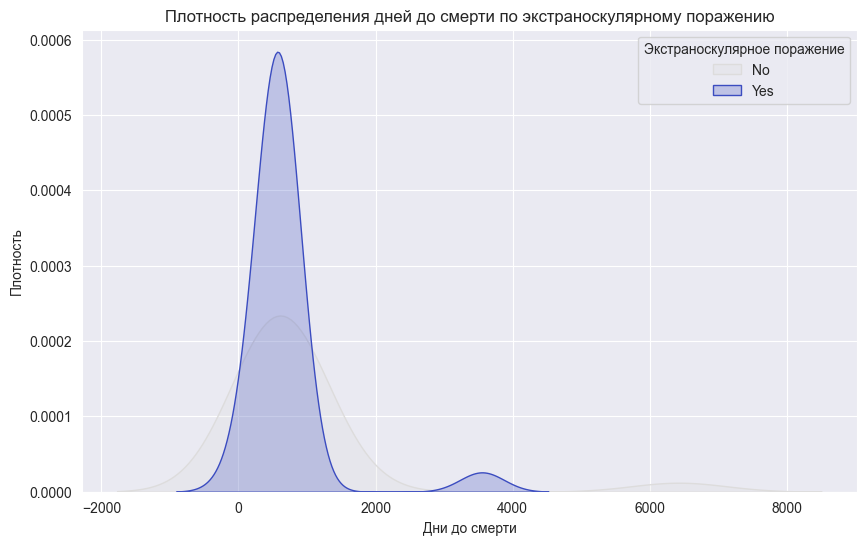

In [179]:
# Построение графика распределения дней до смерти по наличию экстраноскулярного поражения
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='days_to_death', hue='ann_arbor_extranodal_involvement', palette='coolwarm', fill=True)
plt.title('Плотность распределения дней до смерти по экстраноскулярному поражению')
plt.xlabel('Дни до смерти')
plt.ylabel('Плотность')
plt.legend(title='Экстраноскулярное поражение', labels=['No', 'Yes'])
plt.show()

Гипотеза (H1): Пациенты с экстраноскулярным поражением (всего или частично) имеют среднее время до смерти, отличающееся от пациентов без экстраноскулярного поражения. В частности, предположим, что наличие экстраноскулярного поражения связано с более коротким временем до смерти.

Нулевая гипотеза (H0): Наличие или отсутствие экстраноскулярного поражения не влияет на среднее время до смерти пациентов.

In [180]:
from scipy.stats import mannwhitneyu

# Разделение данных на две группы
group_no_extranodal = df[df['ann_arbor_extranodal_involvement'] == 0]['days_to_death']
group_yes_extranodal = df[df['ann_arbor_extranodal_involvement'] == 1]['days_to_death']

# Тест Уилкоксона-Манна-Уитни
stat, p_value = mannwhitneyu(group_no_extranodal, group_yes_extranodal)

print(f'Statistic: {stat}')
print(f'P-value: {p_value}')

Statistic: 220.5
P-value: 0.16593065880934477


In [181]:
if p < 0.05:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Мы не отвергаем нулевую гипотезу.")

Мы не отвергаем нулевую гипотезу.
